In [1]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt

# DEFINIMOS PARAMETROS GLOBALES

seed(seed=42)
np.random.seed(42)

print("Primeros ruidos:", np.random.randn(5))

start_scope()

dt_val = 1.0

defaultclock.dt = dt_val*ms  # Timestep global

simulated_time = 1000*ms

time_steps = int(simulated_time / defaultclock.dt)

dt_scale = defaultclock.dt / ms  # Escala de tiempo para los pesos sinápticos

# Parámetros exactos del paper
N_exc = 800  # 80% de 1000 neuronas como en el código MATLAB
N_inh = 200  # 20% de 1000 neuronas
N_total = N_exc + N_inh

k = 0.5

r_exc = np.random.rand(N_exc)
r_inh = np.random.rand(N_inh)

noise_scale = np.sqrt(dt_val)**(-1)
syn_scale = 1.0

/home/ubuntu-deduce/Projects/izhikevich/.venv/lib/python3.10/site-packages/setuptools/_distutils/_msvccompiler.py:12: UserWarning: _get_vc_env is private; find an alternative (pypa/distutils#340)
  warnings.warn(


Primeros ruidos: [ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337]


In [2]:
# Pre-generar ruido talámico para toda la simulación
time_steps = int(simulated_time / defaultclock.dt)
noise_exc = np.random.randn(time_steps, N_exc) * 5.0 * noise_scale
noise_inh = np.random.randn(time_steps, N_inh) * 2.0 * noise_scale

# Combinar en un solo array
noise_combined = np.concatenate([noise_exc, noise_inh], axis=1)
stimulus_thalamic = TimedArray(noise_combined, dt=dt_val*ms)
    

In [3]:
#  Reemplazar TimedArray con múltiples inputs Poisson
# poisson_exc_A = PoissonInput(exc_neurons_A, 'I_thalamic', N=100, rate=10*Hz, weight=0.05)
# poisson_exc_B = PoissonInput(exc_neurons_B, 'I_thalamic', N=100, rate=10*Hz, weight=0.05)
# poisson_inh_A = PoissonInput(inh_neurons_A, 'I_thalamic', N=40, rate=10*Hz, weight=0.05)
# poisson_inh_B = PoissonInput(inh_neurons_B, 'I_thalamic', N=40, rate=10*Hz, weight=0.05)

# # Ecuaciones sin stimulus:
# I_thalamic : 1  # Se actualiza automáticamente por PoissonInput

In [4]:
noise_scale = 1 #(1/2.0)*np.sqrt(float(defaultclock.dt/ms))**(-1)

noise_exc_A = np.random.randn(time_steps, N_exc) * 5.0   #+ np.random.randn(1100, N_exc) * 0.1# 10s @ 1ms resolution
noise_inh_A = np.random.randn(time_steps, N_inh) * 2.0 
stimulus_exc_A = TimedArray(noise_exc_A, dt=1*ms)
stimulus_inh_A = TimedArray(noise_inh_A, dt=1*ms)

noise_exc_B = np.random.randn(time_steps, N_exc) * 5.0   #+ np.random.randn(1100, N_exc) * 0.1# 10s @ 1ms resolution
noise_inh_B = np.random.randn(time_steps, N_inh) * 2.0 
stimulus_exc_B = TimedArray(noise_exc_B, dt=1*ms)
stimulus_inh_B = TimedArray(noise_inh_B, dt=1*ms)

In [5]:
# DEFINIMOS EL GRUPO NEURONAL A

# MODELO NEURONAL DEL GRUPO A - E/I

# Ecuaciones exactas del paper
equations_exc_A = '''
dv/dt = (0.04*v**2 + 5*v + 140 - u + I_syn + I_thalamic)/ms : 1
du/dt = a*(b*v - u)/ms : 1 
I_syn : 1
I_thalamic = stimulus_exc_A(t, i) : 1 
a : 1
b : 1  
c : 1
d : 1
'''

equations_inh_A = '''
dv/dt = (0.04*v**2 + 5*v + 140 - u + I_syn + I_thalamic)/ms : 1
du/dt = a*(b*v - u)/ms : 1 
I_syn : 1 
I_thalamic = stimulus_inh_A(t,i) : 1
a : 1
b : 1  
c : 1
d : 1
'''

# CREAMOS GRUPOS CON THRESHOLD, RESET Y MÉTODO

# Crear grupos separados
exc_neurons_A = NeuronGroup(N_exc, equations_exc_A, 
                          threshold='v >= 30',
                          reset='v = c; u += d',
                          method='euler')

inh_neurons_A = NeuronGroup(N_inh, equations_inh_A,
                          threshold='v >= 30', 
                          reset='v = c; u += d',
                          method='euler')

# DEFINIMOS LOS PARÁMETROS DEL GRUPO A DE NEURONAS - HETEROGENEIDAD

# Excitatorias: (a,b) = (0.02, 0.2), (c,d) = (-65, 8) + (15, -6)r²
exc_neurons_A.a = 0.02
exc_neurons_A.b = 0.2
exc_neurons_A.c = -65 + 15 * r_exc**2
exc_neurons_A.d = 8 - 6 * r_exc**2


# Inhibitorias: (a,b) = (0.02, 0.25) + (0.08, -0.05)r, (c,d) = (-65, 2)
inh_neurons_A.a = 0.02 + 0.08 * r_inh
inh_neurons_A.b = 0.25 - 0.05 * r_inh
inh_neurons_A.c = -65
inh_neurons_A.d = 2

# CONDICIONES INICIALES ALEATORIAS DEL GRUPO A 

exc_neurons_A.v = -65 + 5*np.random.randn(N_exc) 
exc_neurons_A.u = exc_neurons_A.b * exc_neurons_A.v
inh_neurons_A.v = -65 + 5*np.random.randn(N_inh) 
inh_neurons_A.u = inh_neurons_A.b * inh_neurons_A.v

# DEFINIMOS LA CONECTIVIDAD SINAPTICA DEL GRUPO A - ALL-TO-ALL
# Matriz S: [0.5*rand(Ne+Ni,Ne), -rand(Ne+Ni,Ni)]

reset_clock = Clock(dt=defaultclock.dt)
# RESET DE INPUT SINÁPTICO PARA EL GRUPO A
exc_neurons_A.run_regularly('I_syn = 0', when='before_synapses', clock=reset_clock)
inh_neurons_A.run_regularly('I_syn = 0', when='before_synapses', clock=reset_clock)

# DEFINIMOS CONECTIVIDAD, PESOS SINAPTICOS Y RETRASOS DEL GRUPO A

# 1. Excitatorias -> Excitatorias
syn_ee_A = Synapses(exc_neurons_A, exc_neurons_A, 'w : 1', on_pre='I_syn += w', clock=reset_clock)
syn_ee_A.connect(p=1.0)
syn_ee_A.w = 'k * rand()'
syn_ee_A.delay = '0*ms' # 'rand() * 12*ms'

# 2. Excitatorias -> Inhibitorias  
syn_ei_A = Synapses(exc_neurons_A, inh_neurons_A, 'w : 1', on_pre='I_syn += w', clock=reset_clock)
syn_ei_A.connect(p=1.0)
syn_ei_A.w = 'k * rand()'
syn_ei_A.delay = '0*ms' #'rand() * 12*ms'

# 3. Inhibitorias -> Excitatorias
syn_ie_A = Synapses(inh_neurons_A, exc_neurons_A, 'w : 1', on_pre='I_syn += w', clock=reset_clock)
syn_ie_A.connect(p=1.0)
syn_ie_A.w = '-2*k*rand()'
syn_ie_A.delay = '0*ms' #'rand() * 2*ms'

# 4. Inhibitorias -> Inhibitorias
syn_ii_A = Synapses(inh_neurons_A, inh_neurons_A, 'w : 1', on_pre='I_syn += w', clock=reset_clock)
syn_ii_A.connect(p=1.0)
syn_ii_A.w = '-2*k*rand()'
syn_ii_A.delay = '0*ms' #'rand() * 2*ms'

In [6]:
# DEFINIMOS EL GRUPO NEURONAL B

# MODELO NEURONAL DEL GRUPO B - E/I

# Ecuaciones exactas del paper
equations_exc_B = '''
dv/dt = (0.04*v**2 + 5*v + 140 - u + I_syn + I_thalamic)/ms : 1
du/dt = a*(b*v - u)/ms : 1 
I_syn : 1
I_thalamic = stimulus_exc_B(t, i) : 1
a : 1
b : 1  
c : 1
d : 1
'''

equations_inh_B = '''
dv/dt = (0.04*v**2 + 5*v + 140 - u + I_syn + I_thalamic)/ms : 1
du/dt = a*(b*v - u)/ms : 1 
I_syn : 1 
I_thalamic = stimulus_inh_B(t,i) : 1
a : 1
b : 1  
c : 1
d : 1
'''

# CREAMOS GRUPOS CON THRESHOLD, RESET Y MÉTODO

# Crear grupos separados
exc_neurons_B = NeuronGroup(N_exc, equations_exc_B, 
                          threshold='v >= 30',
                          reset='v = c; u += d',
                          method='euler')

inh_neurons_B = NeuronGroup(N_inh, equations_inh_B,
                          threshold='v >= 30', 
                          reset='v = c; u += d',
                          method='euler')

# DEFINIMOS LOS PARÁMETROS DEL GRUPO B DE NEURONAS - HETEROGENEIDAD

# Excitatorias: (a,b) = (0.02, 0.2), (c,d) = (-65, 8) + (15, -6)r²
exc_neurons_B.a = 0.02
exc_neurons_B.b = 0.2
exc_neurons_B.c = -65 + 15 * r_exc**2
exc_neurons_B.d = 8 - 6 * r_exc**2


# Inhibitorias: (a,b) = (0.02, 0.25) + (0.08, -0.05)r, (c,d) = (-65, 2)
inh_neurons_B.a = 0.02 + 0.08 * r_inh
inh_neurons_B.b = 0.25 - 0.05 * r_inh
inh_neurons_B.c = -65
inh_neurons_B.d = 2

# CONDICIONES INICIALES ALEATORIAS DEL GRUPO B 

exc_neurons_B.v = -65 + 5*np.random.randn(N_exc) 
exc_neurons_B.u = exc_neurons_B.b * exc_neurons_B.v
inh_neurons_B.v = -65 + 5*np.random.randn(N_inh) 
inh_neurons_B.u = inh_neurons_B.b * inh_neurons_B.v

# DEFINIMOS LA CONECTIVIDAD SINAPTICA DEL GRUPO B - ALL-TO-ALL
# Matriz S: [0.5*rand(Ne+Ni,Ne), -rand(Ne+Ni,Ni)]

# RESET DE INPUT SINÁPTICO PARA EL GRUPO B
exc_neurons_B.run_regularly('I_syn = 0', when='before_synapses', clock=reset_clock)
inh_neurons_B.run_regularly('I_syn = 0', when='before_synapses', clock=reset_clock)

# DEFINIMOS CONECTIVIDAD, PESOS SINAPTICOS Y RETRASOS DEL GRUPO B

# 1. Excitatorias -> Excitatorias
syn_ee_B = Synapses(exc_neurons_B, exc_neurons_B, 'w : 1', on_pre='I_syn += w', clock=reset_clock)
syn_ee_B.connect(p=1.0)
syn_ee_B.w = 'k * rand()'
syn_ee_B.delay = '0*ms' # 'rand() * 12*ms'

# 2. Excitatorias -> Inhibitorias  
syn_ei_B = Synapses(exc_neurons_B, inh_neurons_B, 'w : 1', on_pre='I_syn += w', clock=reset_clock)
syn_ei_B.connect(p=1.0)
syn_ei_B.w = 'k * rand()'
syn_ei_B.delay = '0*ms' #'rand() * 12*ms'

# 3. Inhibitorias -> Excitatorias
syn_ie_B = Synapses(inh_neurons_B, exc_neurons_B, 'w : 1', on_pre='I_syn += w', clock=reset_clock)
syn_ie_B.connect(p=1.0)
syn_ie_B.w = '-2*k*rand()'
syn_ie_B.delay = '0*ms' #'rand() * 2*ms'

# 4. Inhibitorias -> Inhibitorias
syn_ii_B = Synapses(inh_neurons_B, inh_neurons_B, 'w : 1', on_pre='I_syn += w', clock=reset_clock)
syn_ii_B.connect(p=1.0)
syn_ii_B.w = '-2*k*rand()'
syn_ii_B.delay = '0*ms' #'rand() * 2*ms'

In [7]:
# # DEFINIMOS LAS CONEXIONES SINAPTICAS ENTRE GRUPOS

# # E_A -> E_B
# syn_ee = Synapses(exc_neurons_A, exc_neurons_B, 'w : 1', on_pre='I_syn += w')
# syn_ee.connect(p=0.01)
# syn_ee.w = '4*k*rand()'
# syn_ee.delay = '10*ms' # 'rand() * 12*ms'

# # E_A -> I_B
# syn_ei = Synapses(exc_neurons_A, inh_neurons_B, 'w : 1', on_pre='I_syn += w')
# syn_ei.connect(p=0.01)
# syn_ei.w = '4*k*rand()'
# syn_ei.delay = '10*ms' #'rand() * 12*ms'

# # E_B -> E_A
# syn_ie = Synapses(exc_neurons_B, exc_neurons_A, 'w : 1', on_pre='I_syn += w')
# syn_ie.connect(p=0.01)
# syn_ie.w = '4*k*rand()'
# syn_ie.delay = '10*ms' #'rand() * 2*ms'

# # E_B-> I_A
# syn_ii = Synapses(exc_neurons_B, inh_neurons_A, 'w : 1', on_pre='I_syn += w')
# syn_ii.connect(p=0.01)
# syn_ii.w = '4*k*rand()'
# syn_ii.delay = '10*ms' #'rand() * 2*ms'


In [8]:
# Factor de escalado para mantener misma varianza por unidad de tiempo
# noise_scale = 1 #(1/2.0)*np.sqrt(float(defaultclock.dt/ms))**(-1)
# noise_scale = float(defaultclock.dt/ms)**(-1)
# # Control manual del input talámico
# @network_operation(dt=1.0*ms)
# def update_input():
#     # Input gaussiano para neuronas excitatorias
#     exc_neurons_A.I_thalamic = 5 * noise_scale * np.random.randn(N_exc)
#     exc_neurons_B.I_thalamic = 5 * noise_scale * np.random.randn(N_exc)

#     # Input gaussiano para neuronas inhibitorias  
#     inh_neurons_A.I_thalamic = 2 * noise_scale * np.random.randn(N_inh)
#     inh_neurons_B.I_thalamic = 2 * noise_scale * np.random.randn(N_inh)


In [9]:
# Monitoreo

state_mon_exc_A = StateMonitor(exc_neurons_A, ['v'], record=range(0, min(100, N_exc), 1))
state_mon_inh_A = StateMonitor(inh_neurons_A, ['v'], record=range(0, min(100, N_exc), 1))

state_mon_exc_B = StateMonitor(exc_neurons_B, ['v'], record=range(0, min(100, N_exc), 1))
state_mon_inh_B = StateMonitor(inh_neurons_B, ['v'], record=range(0, min(100, N_exc), 1))

# Monitores de corriente sináptica (que ya tienes)
I_synaptic_exc_mon_A = StateMonitor(exc_neurons_A, 'I_syn', record=True)
I_synaptic_inh_mon_A = StateMonitor(inh_neurons_A, 'I_syn', record=True)

I_thalamic_exc_mon_A = StateMonitor(exc_neurons_A, 'I_thalamic', record=True)
I_thalamic_inh_mon_A = StateMonitor(inh_neurons_A, 'I_thalamic', record=True)

I_synaptic_exc_mon_B = StateMonitor(exc_neurons_B, 'I_syn', record=True)
I_synaptic_inh_mon_B = StateMonitor(inh_neurons_B, 'I_syn', record=True)

I_thalamic_exc_mon_B = StateMonitor(exc_neurons_B, 'I_thalamic', record=True)
I_thalamic_inh_mon_B = StateMonitor(inh_neurons_B, 'I_thalamic', record=True)

print("Simulando modelo exacto del paper...")

spike_mon_exc_A = SpikeMonitor(exc_neurons_A)
spike_mon_inh_A = SpikeMonitor(inh_neurons_A)

spike_mon_exc_B = SpikeMonitor(exc_neurons_B)
spike_mon_inh_B = SpikeMonitor(inh_neurons_B)

run(simulated_time)

Simulando modelo exacto del paper...


In [10]:
print(f"Synapse clock dt: {reset_clock.dt}")
print(f"Default clock dt: {defaultclock.dt}")
print(f"Neuron clock dt: {exc_neurons_A.clock.dt}")

Synapse clock dt: 1. ms
Default clock dt: 1. ms
Neuron clock dt: 1. ms


In [12]:
import os
os.chdir("../..")
os.getcwd()

'/home/ubuntu-deduce/Projects/izhikevich'

WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/metrics.py:549: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]


nperseg=499, noverlap=124, len(signal_A)=3996

=== Análisis de Conectividad - Baseline ===
Cross-correlation peak: 0.756 at 6.0ms
PLV Alpha: 0.718
PLI Alpha: 0.687
PLV Gamma: 0.485
PLI Gamma: 0.485
Coherence peak: 0.550 at 0.0Hz
Intrinsic timescales: Pop A = 6.7ms (poor), Pop B = 5.9ms (poor)


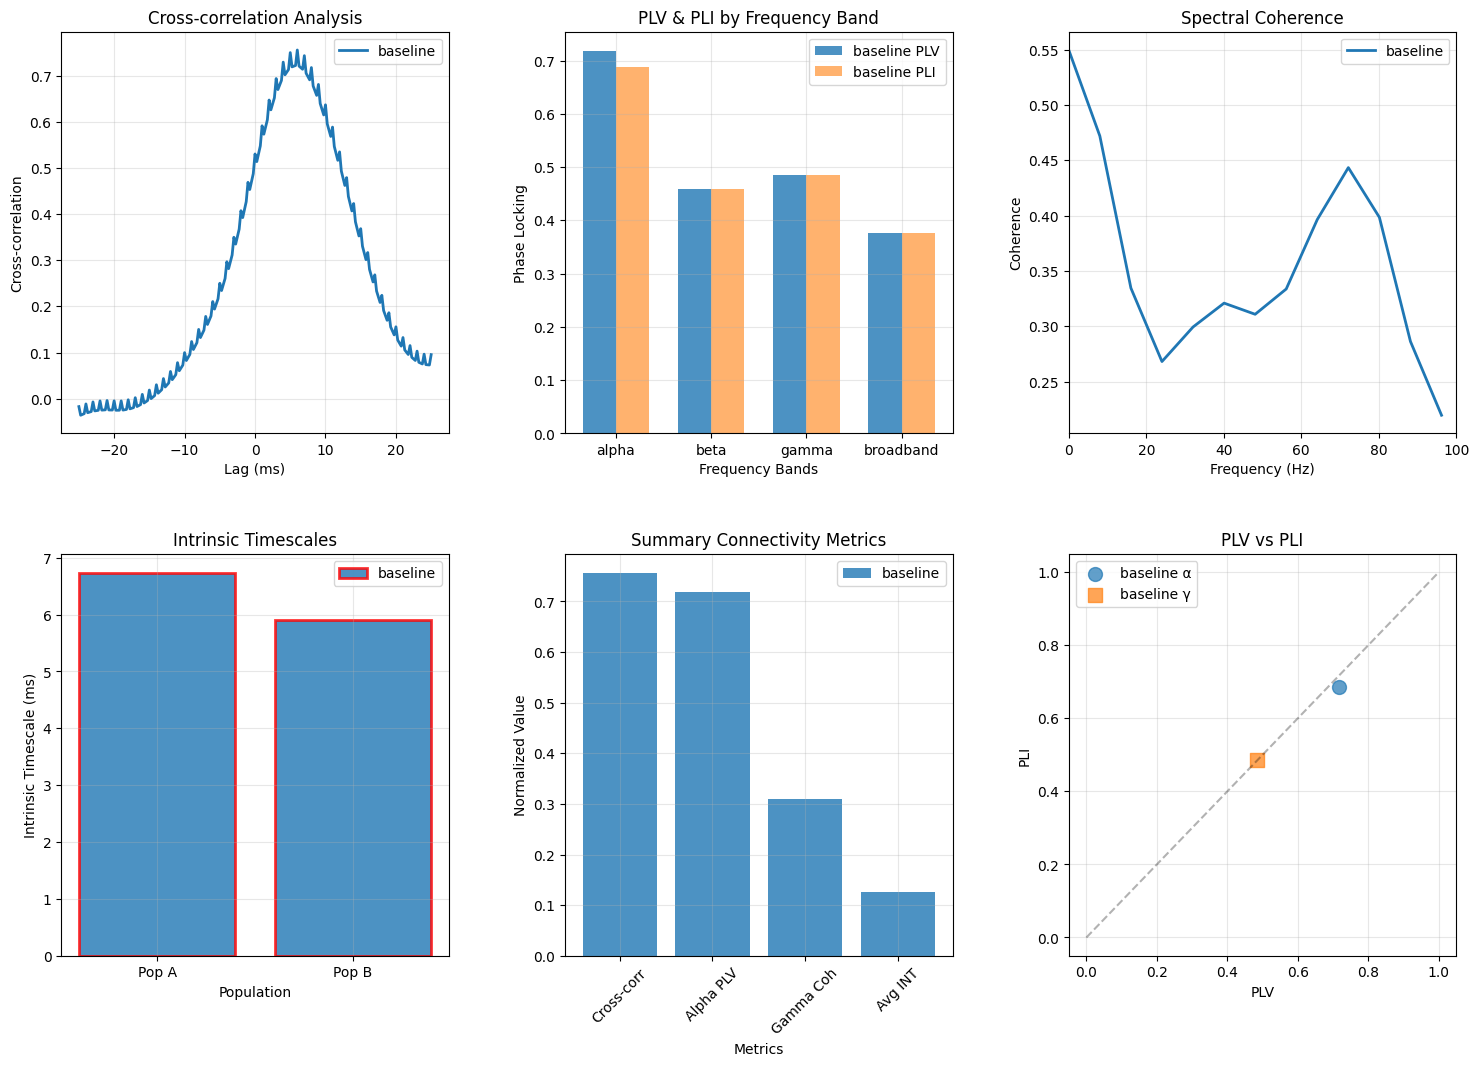

In [13]:
from src.two_populations.metrics import plot_connectivity_dashboard, analyze_simulation_results

results_dict = {}

# Método 1: Directo con monitores Brian2

# Una línea para analizar
results_dict = {
    'baseline': analyze_simulation_results(spike_mon_exc_A, spike_mon_exc_B, N_exc, "Baseline")
}

# Dashboard
fig = plot_connectivity_dashboard(results_dict)
plt.show()

(0.0, 1000.0)

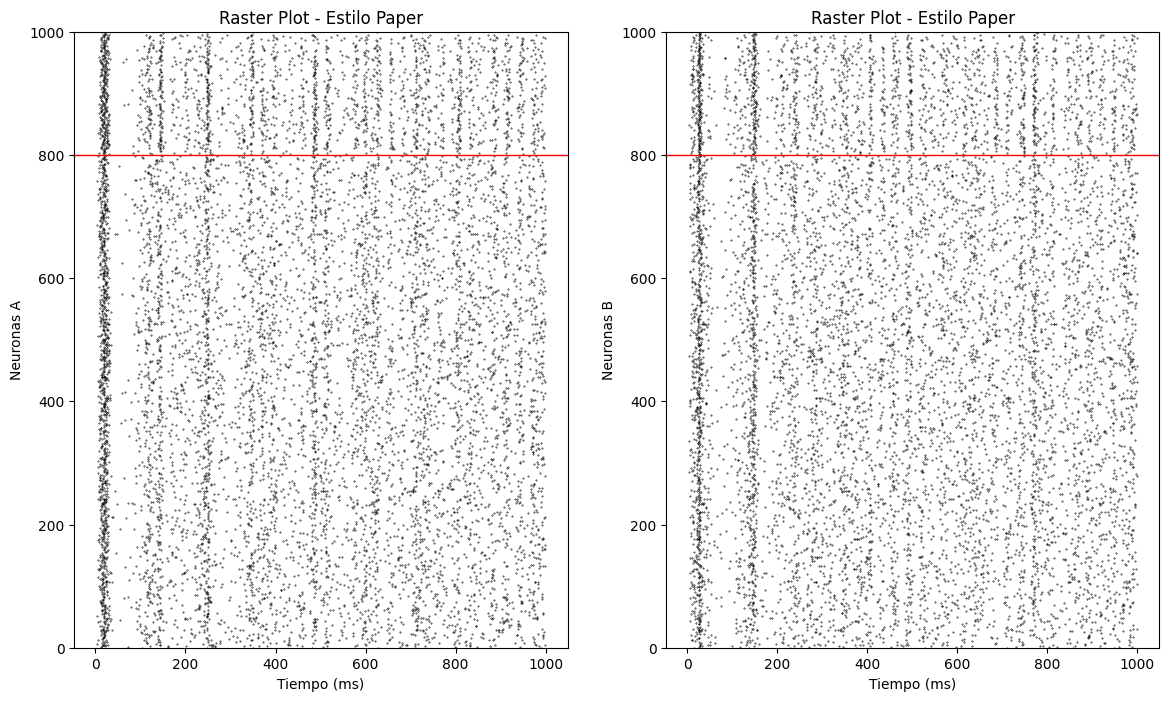

In [14]:
figure(figsize=(14, 8))

# 1. Raster plot estilo paper - Grupo A
subplot(1, 2, 1)
plot(spike_mon_exc_A.t/ms, spike_mon_exc_A.i, '.k', markersize=0.7)
plot(spike_mon_inh_A.t/ms, spike_mon_inh_A.i + N_exc, '.k', markersize=0.7)
axhline(y=N_exc, color='r', linestyle='-', linewidth=1)
xlabel('Tiempo (ms)')
ylabel('Neuronas A')
title('Raster Plot - Estilo Paper')
ylim(0, N_total)

# 1. Raster plot estilo paper - Grupo B
subplot(1, 2, 2)
plot(spike_mon_exc_B.t/ms, spike_mon_exc_B.i, '.k', markersize=0.7)
plot(spike_mon_inh_B.t/ms, spike_mon_inh_B.i + N_exc, '.k', markersize=0.7)
axhline(y=N_exc, color='r', linestyle='-', linewidth=1)
xlabel('Tiempo (ms)')
ylabel('Neuronas B')
title('Raster Plot - Estilo Paper')
ylim(0, N_total)

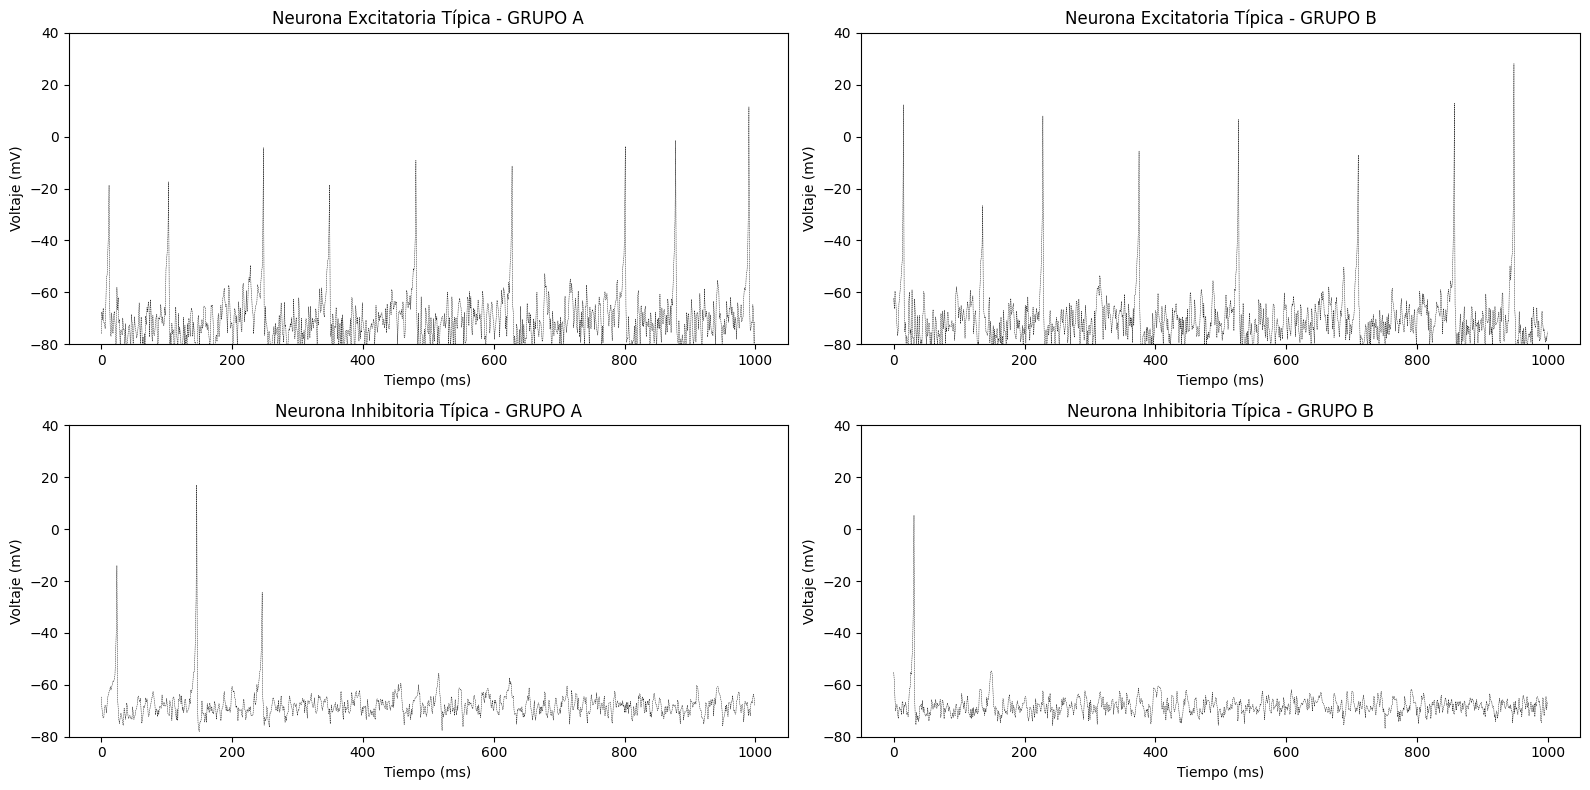

In [15]:
figure(figsize=(16, 8))

# 2. Voltaje de neurona típica
subplot(2, 2, 1)
neuron_idx = 0
plot(state_mon_exc_A.t/ms, state_mon_exc_A.v[neuron_idx],'--', linewidth=0.3, color = 'black')
xlabel('Tiempo (ms)')
ylabel('Voltaje (mV)')
title('Neurona Excitatoria Típica - GRUPO A')
ylim(-80, 40)

subplot(2, 2, 2)
plot(state_mon_exc_B.t/ms, state_mon_exc_B.v[neuron_idx], '--', linewidth=0.3, color = 'black')
xlabel('Tiempo (ms)')
ylabel('Voltaje (mV)')
title('Neurona Excitatoria Típica - GRUPO B')
ylim(-80, 40)

subplot(2, 2, 3)
neuron_idx = 0
plot(state_mon_inh_A.t/ms, state_mon_inh_A.v[neuron_idx], '--', linewidth=0.3, color = 'black')
xlabel('Tiempo (ms)')
ylabel('Voltaje (mV)')
title('Neurona Inhibitoria Típica - GRUPO A')
ylim(-80, 40)

subplot(2, 2, 4)
plot(state_mon_inh_B.t/ms, state_mon_inh_B.v[neuron_idx], '--', linewidth=0.3, color = 'black')
xlabel('Tiempo (ms)')
ylabel('Voltaje (mV)')
title('Neurona Inhibitoria Típica - GRUPO B')
ylim(-80, 40)

tight_layout()

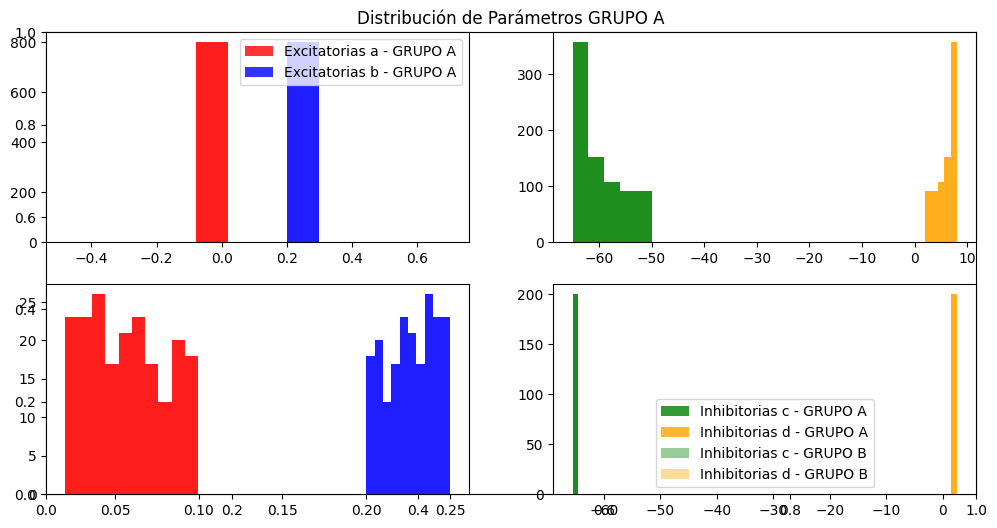

In [16]:
figure(figsize=(12, 6))

title('Distribución de Parámetros GRUPO A')

# 3. Distribución de parámetros para el grupo A
subplot(2, 2, 1)
hist(exc_neurons_A.a, alpha=0.8, color='red', bins= 10, label='Excitatorias a - GRUPO A')
hist(exc_neurons_A.b, alpha=0.8, color='blue', bins= 10,label='Excitatorias b - GRUPO A')
legend()
subplot(2, 2, 2)
hist(exc_neurons_A.c, alpha=0.8, color='green', bins= 5,label='Excitatorias c - GRUPO A')
hist(exc_neurons_A.d, alpha=0.8, color='orange', bins= 5,label='Excitatorias d - GRUPO A')

subplot(2, 2, 3)
hist(inh_neurons_A.a, alpha=0.8, color='red', bins= 10,label='Inhibitorias a - GRUPO A')
hist(inh_neurons_A.b, alpha=0.8, color='blue', bins= 10,label='Inhibitorias b - GRUPO A')
subplot(2, 2, 4)
hist(inh_neurons_A.c, alpha=0.8, color='green', bins= 1,label='Inhibitorias c - GRUPO A')
hist(inh_neurons_A.d, alpha=0.8, color='orange', bins= 1,label='Inhibitorias d - GRUPO A')

legend()


# title('Distribución de Parámetros GRUPO B')

# 3. Distribución de parámetros para el grupo B
subplot(2, 2, 1)
hist(exc_neurons_B.a, alpha=0.4, color='red', bins= 10, label='Excitatorias a - GRUPO B')
hist(exc_neurons_B.b, alpha=0.4, color='blue', bins= 10,label='Excitatorias b - GRUPO B')

subplot(2, 2, 2)
hist(exc_neurons_B.c, alpha=0.4, color='green', bins= 5,label='Excitatorias c - GRUPO B')
hist(exc_neurons_B.d, alpha=0.4, color='orange', bins= 5,label='Excitatorias d - GRUPO B')

subplot(2, 2, 3)
hist(inh_neurons_B.a, alpha=0.4, color='red', bins= 10,label='Inhibitorias a - GRUPO B')
hist(inh_neurons_B.b, alpha=0.4, color='blue', bins= 10,label='Inhibitorias b - GRUPO B')
subplot(2, 2, 4)
hist(inh_neurons_B.c, alpha=0.4, color='green', bins= 1,label='Inhibitorias c - GRUPO B')
hist(inh_neurons_B.d, alpha=0.4, color='orange', bins= 1,label='Inhibitorias d - GRUPO B')

legend()

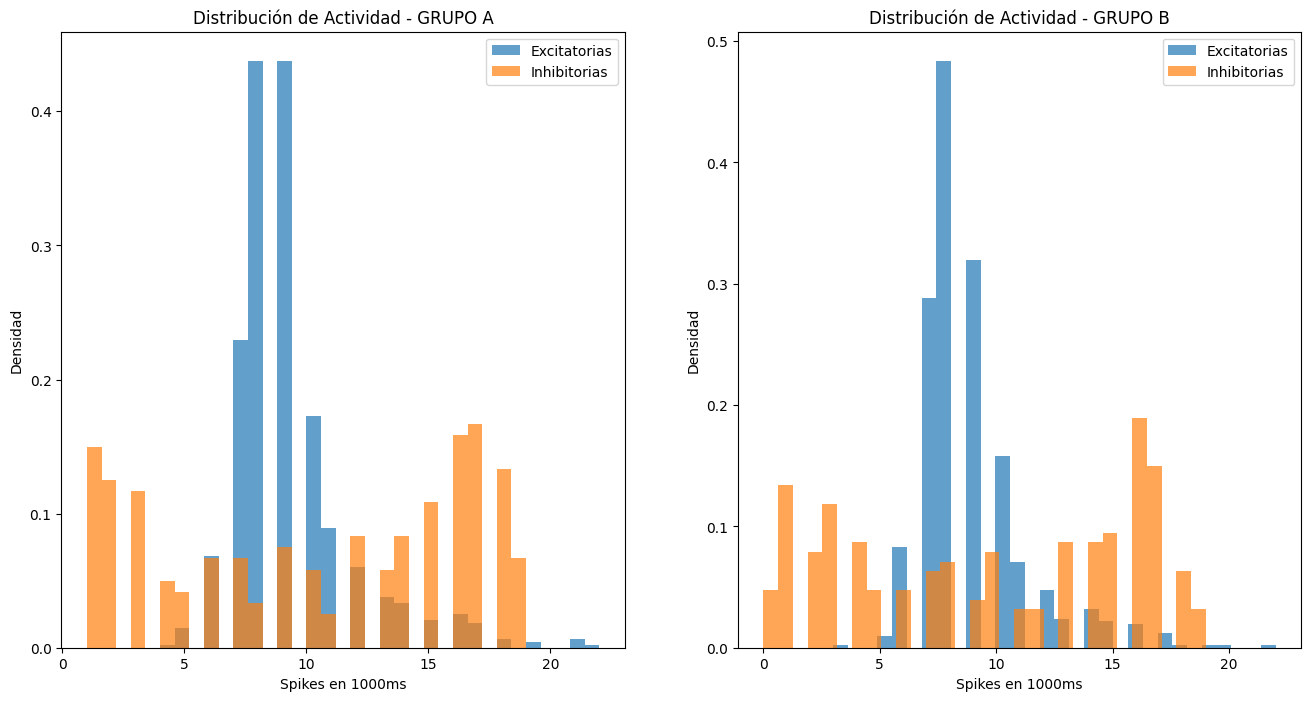

In [17]:
figure(figsize=(16, 8))

# 4. Histograma de frecuencias - GRUPO A

subplot(1,2,1)
freq_exc_A = []
freq_inh_A = []

for i in range(N_exc):
    spike_count = sum(spike_mon_exc_A.i == i)
    freq_exc_A.append(spike_count)

for i in range(N_inh):
    spike_count = sum(spike_mon_inh_A.i == i) 
    freq_inh_A.append(spike_count)

hist(freq_exc_A, bins=30, alpha=0.7, density=True, label='Excitatorias')
hist(freq_inh_A, bins=30, alpha=0.7, density=True, label='Inhibitorias')
xlabel('Spikes en 1000ms')
ylabel('Densidad')
title('Distribución de Actividad - GRUPO A')
legend()

# 4. Histograma de frecuencias - GRUPO B

subplot(1,2,2)
freq_exc_B = []
freq_inh_B = []

for i in range(N_exc):
    spike_count = sum(spike_mon_exc_B.i == i)
    freq_exc_B.append(spike_count)

for i in range(N_inh):
    spike_count = sum(spike_mon_inh_B.i == i) 
    freq_inh_B.append(spike_count)

hist(freq_exc_B, bins=30, alpha=0.7, density=True, label='Excitatorias')
hist(freq_inh_B, bins=30, alpha=0.7, density=True, label='Inhibitorias')
xlabel('Spikes en 1000ms')
ylabel('Densidad')
title('Distribución de Actividad - GRUPO B')
legend()

Text(0.5, 1.0, 'Actividad de Red - GRUPO B')

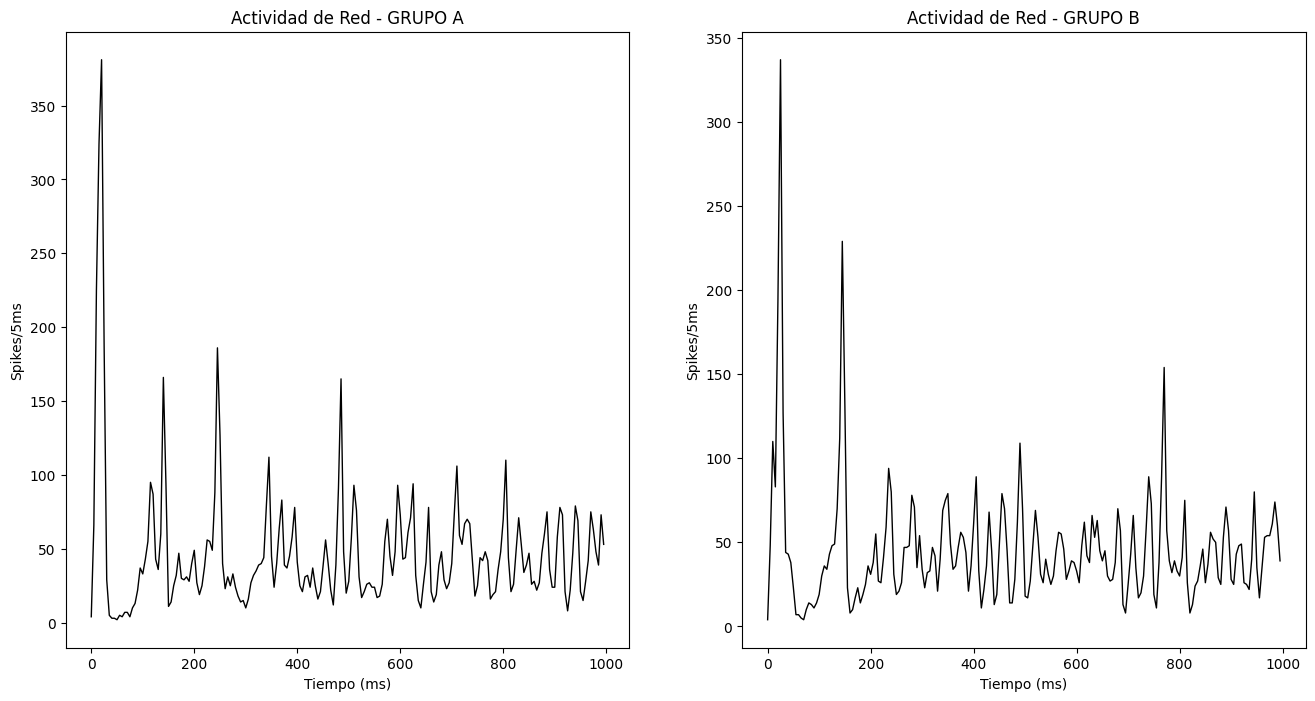

In [18]:
figure(figsize=(16, 8))

# 5. Actividad poblacional (como Fig. 3 del paper)
subplot(1, 2, 1)
bin_size = 5*ms
time_bins = np.arange(0, 1000, bin_size/ms)
activity_A = []

for t in time_bins:
    total_spikes = (sum((spike_mon_exc_A.t >= t*ms) & (spike_mon_exc_A.t < (t + bin_size/ms)*ms)) +
                   sum((spike_mon_inh_A.t >= t*ms) & (spike_mon_inh_A.t < (t + bin_size/ms)*ms)))
    activity_A.append(total_spikes)

plot(time_bins, activity_A, 'k-', linewidth=1)
xlabel('Tiempo (ms)')
ylabel(f'Spikes/{bin_size/ms:.0f}ms')
title('Actividad de Red - GRUPO A')

# 5. Actividad poblacional (como Fig. 3 del paper)
subplot(1, 2, 2)
bin_size = 5*ms
time_bins = np.arange(0, 1000, bin_size/ms)
activity_B = []

for t in time_bins:
    total_spikes = (sum((spike_mon_exc_B.t >= t*ms) & (spike_mon_exc_B.t < (t + bin_size/ms)*ms)) +
                   sum((spike_mon_inh_B.t >= t*ms) & (spike_mon_inh_B.t < (t + bin_size/ms)*ms)))
    activity_B.append(total_spikes)

plot(time_bins, activity_B, 'k-', linewidth=1)
xlabel('Tiempo (ms)')
ylabel(f'Spikes/{bin_size/ms:.0f}ms')
title('Actividad de Red - GRUPO B')

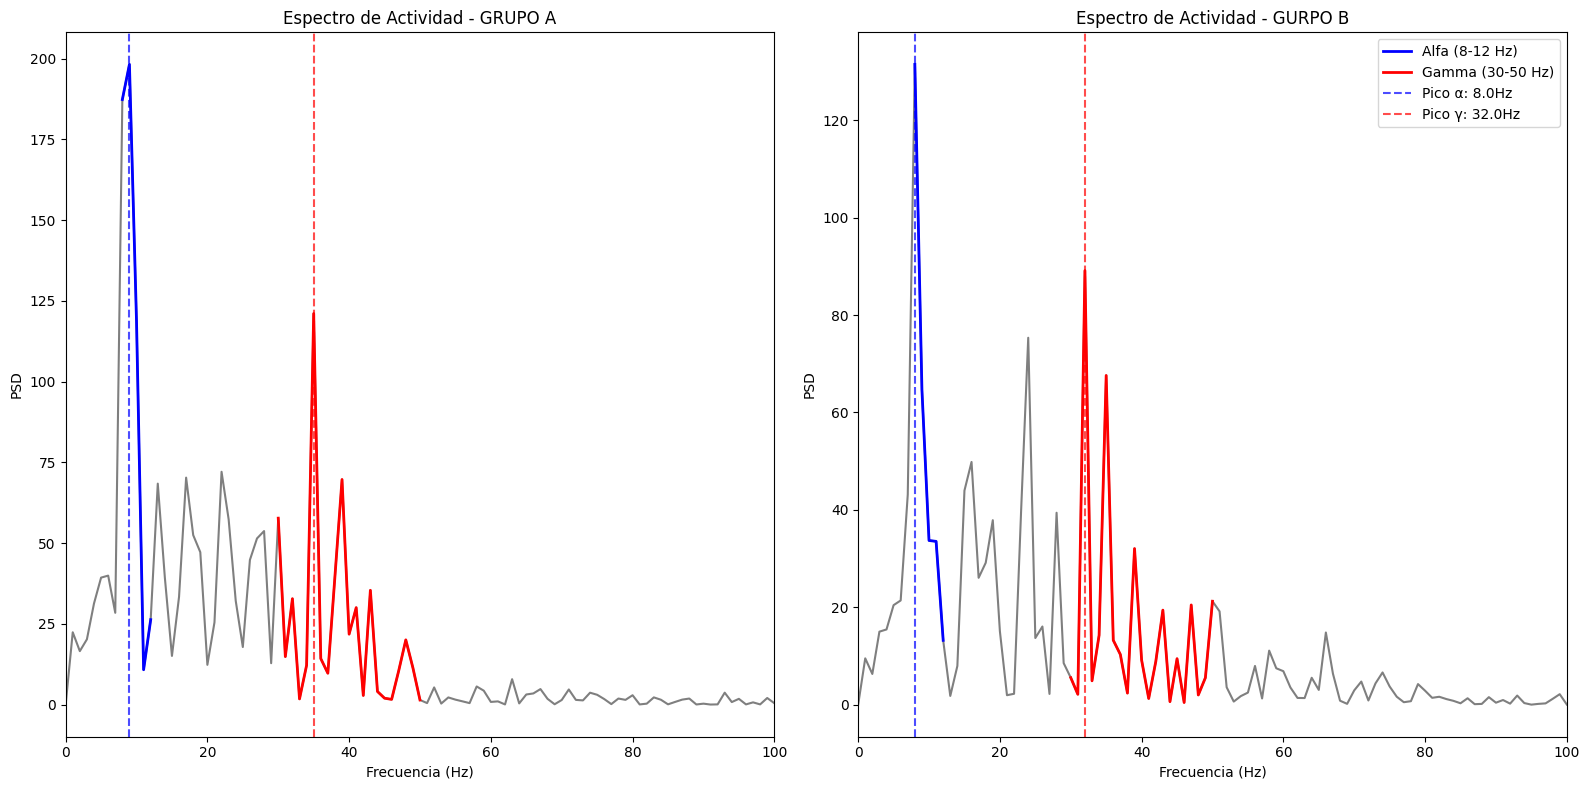

In [19]:
from scipy import signal

figure(figsize=(16, 8))

subplot(1, 2, 1)

# 6. Análisis espectral simple - GRUPO A

if len(activity_A) > 100:

    freqs, psd = signal.periodogram(activity_A, fs=1000/(bin_size/ms))
    
    # Resaltar bandas específicas
    alpha_band = (freqs >= 8) & (freqs <= 12)
    gamma_band = (freqs >= 30) & (freqs <= 50)
    
    plot(freqs, psd, 'k-', alpha=0.5)
    plot(freqs[alpha_band], psd[alpha_band], 'b-', linewidth=2, label='Alfa (8-12 Hz)')
    plot(freqs[gamma_band], psd[gamma_band], 'r-', linewidth=2, label='Gamma (30-50 Hz)')
    
    # Verificar que las bandas tengan datos
    if np.any(alpha_band) and np.any(gamma_band):
        alpha_peak = freqs[alpha_band][np.argmax(psd[alpha_band])]
        gamma_peak = freqs[gamma_band][np.argmax(psd[gamma_band])]
    
    # Usar ymax dinámico en lugar de 1e6 fijo
    ymax = np.max(psd) * 1.1
    axvline(alpha_peak, color='blue', linestyle='--', alpha=0.7, label=f'Pico α: {alpha_peak:.1f}Hz')
    axvline(gamma_peak, color='red', linestyle='--', alpha=0.7, label=f'Pico γ: {gamma_peak:.1f}Hz')

    
    xlabel('Frecuencia (Hz)')
    ylabel('PSD')
    title('Espectro de Actividad - GRUPO A')
    xlim(0, 100)
    
subplot(1, 2, 2)
    
if len(activity_B) > 100:

    freqs, psd = signal.periodogram(activity_B, fs=1000/(bin_size/ms))
    
    # Resaltar bandas específicas
    alpha_band = (freqs >= 8) & (freqs <= 12)
    gamma_band = (freqs >= 30) & (freqs <= 50)
    
    plot(freqs, psd, 'k-', alpha=0.5)
    plot(freqs[alpha_band], psd[alpha_band], 'b-', linewidth=2, label='Alfa (8-12 Hz)')
    plot(freqs[gamma_band], psd[gamma_band], 'r-', linewidth=2, label='Gamma (30-50 Hz)')
    
    # Verificar que las bandas tengan datos
    if np.any(alpha_band) and np.any(gamma_band):
        alpha_peak = freqs[alpha_band][np.argmax(psd[alpha_band])]
        gamma_peak = freqs[gamma_band][np.argmax(psd[gamma_band])]
    
    # Usar ymax dinámico en lugar de 1e6 fijo
    ymax = np.max(psd) * 1.1
    axvline(alpha_peak, color='blue', linestyle='--', alpha=0.7, label=f'Pico α: {alpha_peak:.1f}Hz')
    axvline(gamma_peak, color='red', linestyle='--', alpha=0.7, label=f'Pico γ: {gamma_peak:.1f}Hz')

    
    xlabel('Frecuencia (Hz)')
    ylabel('PSD')
    title('Espectro de Actividad - GURPO B')
    xlim(0, 100)

legend()
tight_layout()


In [20]:
# Estadísticas exactas como en el paper
print(f"\n{'='*60}")
print("COMPARACIÓN CON PAPER ORIGINAL - GRUPO A")
print(f"{'='*60}")
print(f"Arquitectura:")
print(f"  Neuronas: {N_exc} exc + {N_inh} inh (ratio 4:1 ✓)")
print(f"  Conexiones: {len(syn_ee_A.i) + len(syn_ii_A.i)+ len(syn_ie_A.i)+ len(syn_ei_A.i)} totales")
print(f"  Prob. conexión: {(len(syn_ee_A.i) + len(syn_ii_A.i)+ len(syn_ie_A.i)+ len(syn_ei_A.i))/(N_total*N_exc):.3f} (paper: ~0.09)")

print(f"\nActividad:")
total_spikes_exc = len(spike_mon_exc_A.t)
total_spikes_inh = len(spike_mon_inh_A.t)
mean_freq_exc = total_spikes_exc / N_exc  # spikes por neurona en 1s
mean_freq_inh = total_spikes_inh / N_inh

print(f"  Freq. excitatorias: {mean_freq_exc:.1f} Hz (paper: ~8Hz)")
print(f"  Freq. inhibitorias: {mean_freq_inh:.1f} Hz")
print(f"  Spikes totales: {total_spikes_exc + total_spikes_inh}")

print(f"\nParámetros (verificación aleatoria):")
idx = np.random.randint(0, N_exc)
print(f"  Neurona exc #{idx}: c={exc_neurons_A.c[idx]:.1f}, d={exc_neurons_A.d[idx]:.1f}")
idx = np.random.randint(0, N_inh)  
print(f"  Neurona inh #{idx}: a={inh_neurons_A.a[idx]:.3f}, b={inh_neurons_A.b[idx]:.3f}")

print(f"\nComportamiento emergente:")
asynchrony = np.std(activity_A) / np.mean(activity_A)
print(f"  Índice asincronía: {asynchrony:.2f} (>1 = asíncrono ✓)")
active_exc = sum(np.array(freq_exc_A) > 0)
print(f"  Neuronas activas: {active_exc}/{N_exc} ({100*active_exc/N_exc:.1f}%)")


COMPARACIÓN CON PAPER ORIGINAL - GRUPO A
Arquitectura:
  Neuronas: 800 exc + 200 inh (ratio 4:1 ✓)
  Conexiones: 1000000 totales
  Prob. conexión: 1.250 (paper: ~0.09)

Actividad:
  Freq. excitatorias: 9.2 Hz (paper: ~8Hz)
  Freq. inhibitorias: 10.4 Hz
  Spikes totales: 9447

Parámetros (verificación aleatoria):
  Neurona exc #35: c=-61.3, d=6.5
  Neurona inh #161: a=0.044, b=0.235

Comportamiento emergente:
  Índice asincronía: 0.96 (>1 = asíncrono ✓)
  Neuronas activas: 800/800 (100.0%)


In [21]:
# Estadísticas exactas como en el paper
print(f"\n{'='*60}")
print("COMPARACIÓN CON PAPER ORIGINAL - GRUPO B")
print(f"{'='*60}")
print(f"Arquitectura:")
print(f"  Neuronas: {N_exc} exc + {N_inh} inh (ratio 4:1 ✓)")
print(f"  Conexiones: {len(syn_ee_B.i) + len(syn_ii_B.i)+ len(syn_ie_B.i)+ len(syn_ei_B.i)} totales")
print(f"  Prob. conexión: {(len(syn_ee_B.i)+len(syn_ei_B.i)+len(syn_ii_B.i)+len(syn_ie_B.i))/(N_total*N_exc):.3f} (paper: ~0.09)")

print(f"\nActividad:")
total_spikes_exc = len(spike_mon_exc_B.t)
total_spikes_inh = len(spike_mon_inh_B.t)
mean_freq_exc = total_spikes_exc / N_exc  # spikes por neurona en 1s
mean_freq_inh = total_spikes_inh / N_inh

print(f"  Freq. excitatorias: {mean_freq_exc:.1f} Hz (paper: ~8Hz)")
print(f"  Freq. inhibitorias: {mean_freq_inh:.1f} Hz")
print(f"  Spikes totales: {total_spikes_exc + total_spikes_inh}")

print(f"\nParámetros (verificación aleatoria):")
idx = np.random.randint(0, N_exc)
print(f"  Neurona exc #{idx}: c={exc_neurons_B.c[idx]:.1f}, d={exc_neurons_B.d[idx]:.1f}")
idx = np.random.randint(0, N_inh)  
print(f"  Neurona inh #{idx}: a={inh_neurons_B.a[idx]:.3f}, b={inh_neurons_B.b[idx]:.3f}")

print(f"\nComportamiento emergente:")
asynchrony = np.std(activity_B) / np.mean(activity_B)
print(f"  Índice asincronía: {asynchrony:.2f} (>1 = asíncrono ✓)")
active_exc = sum(np.array(freq_exc_B) > 0)
print(f"  Neuronas activas: {active_exc}/{N_exc} ({100*active_exc/N_exc:.1f}%)")


COMPARACIÓN CON PAPER ORIGINAL - GRUPO B
Arquitectura:
  Neuronas: 800 exc + 200 inh (ratio 4:1 ✓)
  Conexiones: 1000000 totales
  Prob. conexión: 1.250 (paper: ~0.09)

Actividad:
  Freq. excitatorias: 8.9 Hz (paper: ~8Hz)
  Freq. inhibitorias: 9.8 Hz
  Spikes totales: 9051

Parámetros (verificación aleatoria):
  Neurona exc #58: c=-63.8, d=7.5
  Neurona inh #88: a=0.073, b=0.217

Comportamiento emergente:
  Índice asincronía: 0.80 (>1 = asíncrono ✓)
  Neuronas activas: 800/800 (100.0%)


In [22]:
def extract_currents_info(I_thalamic_exc_mon, I_thalamic_inh_mon, I_synaptic_exc_mon, I_synaptic_inh_mon):
    I_thal_exc_brian = I_thalamic_exc_mon.I_thalamic         # (1000, 800)
    I_thal_inh_brian = I_thalamic_inh_mon.I_thalamic        # (1000, 200)
    I_syn_exc_brian = I_synaptic_exc_mon.I_syn   # (1000, 800)
    I_syn_inh_brian = I_synaptic_inh_mon.I_syn   # (1000, 200)
    I_tot_exc_brian = I_thal_exc_brian + I_syn_exc_brian
    I_tot_inh_brian = I_thal_inh_brian + I_syn_inh_brian

    stats_brian = {
        'thalamic_exc': {
            'mean_per_neuron': np.mean(I_thal_exc_brian, axis=0),
            'std_per_neuron': np.std(I_thal_exc_brian, axis=0),
            'mean_per_timestep': np.mean(I_thal_exc_brian, axis=1),
            'min_per_timestep': np.min(I_thal_exc_brian, axis=1),
            'max_per_timestep': np.max(I_thal_exc_brian, axis=1)
        },
        'synaptic_exc': {
            'mean_per_neuron': np.mean(I_syn_exc_brian, axis=0),
            'std_per_neuron': np.std(I_syn_exc_brian, axis=0),
            'mean_per_timestep': np.mean(I_syn_exc_brian, axis=1),
            'min_per_timestep': np.min(I_syn_exc_brian, axis=1),
            'max_per_timestep': np.max(I_syn_exc_brian, axis=1)
        },
        'total_exc': {
            'mean_per_neuron': np.mean(I_tot_exc_brian, axis=0),
            'std_per_neuron': np.std(I_tot_exc_brian, axis=0),
            'mean_per_timestep': np.mean(I_tot_exc_brian, axis=1),
            'min_per_timestep': np.min(I_tot_exc_brian, axis=1),
            'max_per_timestep': np.max(I_tot_exc_brian, axis=1)
        },
        'thalamic_inh': {
            'mean_per_neuron': np.mean(I_thal_inh_brian, axis=0),
            'std_per_neuron': np.std(I_thal_inh_brian, axis=0),
            'mean_per_timestep': np.mean(I_thal_inh_brian, axis=1),
            'min_per_timestep': np.min(I_thal_inh_brian, axis=1),
            'max_per_timestep': np.max(I_thal_inh_brian, axis=1)
        },
        'synaptic_inh': {
            'mean_per_neuron': np.mean(I_syn_inh_brian, axis=0),
            'std_per_neuron': np.std(I_syn_inh_brian, axis=0),
            'mean_per_timestep': np.mean(I_syn_inh_brian, axis=1),
            'min_per_timestep': np.min(I_syn_inh_brian, axis=1),
            'max_per_timestep': np.max(I_syn_inh_brian, axis=1)
        },
        'total_inh': {
            'mean_per_neuron': np.mean(I_tot_inh_brian, axis=0),
            'std_per_neuron': np.std(I_tot_inh_brian, axis=0),
            'mean_per_timestep': np.mean(I_tot_inh_brian, axis=1),
            'min_per_timestep': np.min(I_tot_inh_brian, axis=1),
            'max_per_timestep': np.max(I_tot_inh_brian, axis=1)
        }
    }
    
        # Comparar medias
    print("=== INPUT TALÁMICO ===")

    print(f"Brian2 exc - Media por neurona: {np.mean(stats_brian['thalamic_exc']['mean_per_neuron']):.4f}")

    print(f"Brian2 exc - Std por neurona: {np.mean(stats_brian['thalamic_exc']['std_per_neuron']):.4f}")

    print("\n=== INPUT SINÁPTICO ===")

    print(f"Brian2 exc - Media: {np.mean(stats_brian['synaptic_exc']['mean_per_neuron']):.4f}")

    print(f"Brian2 exc - Std: {np.mean(stats_brian['synaptic_exc']['std_per_neuron']):.4f}")

    # Rangos de variación

    print(f"Brian2 exc - Rango típico: [{np.mean(stats_brian['synaptic_exc']['min_per_timestep']):.2f}, {np.mean(stats_brian['synaptic_exc']['max_per_timestep']):.2f}]")
    
    return stats_brian

In [23]:
print("\n=== Estadísticas del Grupo A ===\n")
stats_brian_A = extract_currents_info(I_thalamic_exc_mon_A, I_thalamic_inh_mon_A, I_synaptic_exc_mon_A, I_synaptic_inh_mon_A)
print("\n=== Estadísticas del Grupo B ===\n")
stats_brian_B = extract_currents_info(I_thalamic_exc_mon_B, I_thalamic_inh_mon_B, I_synaptic_exc_mon_B, I_synaptic_inh_mon_B)


=== Estadísticas del Grupo A ===

=== INPUT TALÁMICO ===
Brian2 exc - Media por neurona: -0.0039
Brian2 exc - Std por neurona: 5.0036

=== INPUT SINÁPTICO ===
Brian2 exc - Media: 0.7930
Brian2 exc - Std: 0.5027
Brian2 exc - Rango típico: [-6.06, 8.48]

=== Estadísticas del Grupo B ===

=== INPUT TALÁMICO ===
Brian2 exc - Media por neurona: -0.0017
Brian2 exc - Std por neurona: 4.9951

=== INPUT SINÁPTICO ===
Brian2 exc - Media: 0.7900
Brian2 exc - Std: 0.5030
Brian2 exc - Rango típico: [-4.51, 8.70]


== Estadísticas del Grupo A ===

=== INPUT TALÁMICO ===
Brian2 exc - Media por neurona: -0.0019
Brian2 exc - Std por neurona: 4.9974

=== INPUT SINÁPTICO ===
Brian2 exc - Media: 0.8016
Brian2 exc - Std: 0.5017
Brian2 exc - Rango típico: [-4.84, 9.81]

=== Estadísticas del Grupo B ===

=== INPUT TALÁMICO ===
Brian2 exc - Media por neurona: -0.0039
Brian2 exc - Std por neurona: 5.0036

=== INPUT SINÁPTICO ===
Brian2 exc - Media: 0.8246
Brian2 exc - Std: 0.5066
Brian2 exc - Rango típico: [-4.62, 6.72]